In [762]:
import qutip.core.gates
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

In [763]:
def print_gadget(gadget):
    # Build and print the tensor representation
    tensor_representation = []
    for op in gadget:
        # Check for identity
        if op == I:
            tensor_representation.append("I")
        # Check for standard operators
        elif op == X:
            tensor_representation.append("X")
        elif op == Z:
            tensor_representation.append("Z")
        elif op == Y:
            tensor_representation.append("Y")
        # Check for 0.5(I - Z)
        elif (
            isinstance(op, Qobj)  # Ensure it's a Qobj
            and op.dims == I.dims  # Match single-qubit operator dimensions
            and np.allclose(op.full(), (0.5 * I - 0.5 * Z).full())  # Compare matrices
        ):
            tensor_representation.append("1/2(I-Z)")
        # Fallback for unknown operators
        else:
            tensor_representation.append("Unknown")
    
    print(f"tensor({', '.join(tensor_representation)})")
    
    
def tensor_to_str(operator):
    # Build and print the tensor representation
    tensor_representation = []
    for op in operator:
        # Check for identity
        if op == I:
            tensor_representation.append("I")
        # Check for standard operators
        elif op == X:
            tensor_representation.append("X")
        elif op == Z:
            tensor_representation.append("Z")
        elif op == Y:
            tensor_representation.append("Y")
        else:
            tensor_representation.append("Unknown")
    
    return f"{''.join(tensor_representation)}"

In [764]:
def prep_aux_gad(k, current_position):
    aux_H = 0.5 * (tensor([0.5 * (I - (Z if j  == i else I)) for i in range(k)]))
    
    # Embed aux_H into the full space
    pre_space = [I for _ in range(current_position)]  # Identities before this auxiliary block
    post_space = [I for _ in range(tot_space - current_position - k)]  # Identities after this block    
    full_aux_H = tensor(pre_space + [aux_H] + post_space)


    ####### FOR PRINTING Aux #######
    to_p = (
        pre_space
        + [0.5 * (I - (Z if j  == i else I)) for i in range(k)]
        + post_space
    )
    print_gadget(to_p)
    ####### FOR PRINTING Aux #######


    return full_aux_H


def prep_aux_gad_jordan(k, i, current_position):
    # Construct the ancillary Hamiltonian
    anc_accum = 0
    for j in range(i + 1, k):
        # Construct the pairwise interaction term for the ancillary space
        aux = [0.5*(I - (Z if idx == i or idx == j else I)) for idx in range(k)]
        aux_H = tensor(aux)
        
    
        # Embed aux_H into the full space
        pre_space = [I for _ in range(current_position)]  # Identities before this auxiliary block
        post_space = [I for _ in range(tot_space - current_position - k)]  # Identities after this block
        full_aux_H = tensor(pre_space + [aux_H] + post_space)
        
        anc_accum += full_aux_H
        ###### FOR PRINTING Aux #######
        to_p = (pre_space + aux + post_space)
        print_gadget(to_p)
        ###### FOR PRINTING Aux #######
        
    return anc_accum


def prep_v_gad(k, j, aux_count_v, current_position):
    logical_operator = tensor(
        [op if i == j else I for i in range(total_logic_qbits)]
    )
    
    # auxiliary_operator = tensor([X if i == (j % k) else X if i == (j + 1) % k else I for i in range(k)])
    aux = [X if i == aux_count_v else I for i in range(k)]
    auxiliary_operator = tensor(aux)
    
    # Embed auxiliary operator into the full auxiliary space
    pre_aux = [I for _ in range(current_position - total_logic_qbits)]  # Identities for earlier stabilizers
    post_aux = [I for _ in range(sum(ks[index + 1:]))]  # Identities for remaining stabilizers
    full_auxiliary_operator = tensor(pre_aux + [auxiliary_operator] + post_aux)
    
    # Combine logical and full auxiliary operators
    full_v = tensor(logical_operator, full_auxiliary_operator)            

    ####### FOR PRINTING V #######
    # to_p = [op if i == j else I for i in range(total_logic_qbits)] + pre_aux + [X if i == (j % k) else X if i == (j + 1) % k else I for i in range(k)] + post_aux
    to_p = [op if i == j else I for i in range(total_logic_qbits)] + pre_aux + aux + post_aux
    print_gadget(to_p)
    ####### FOR PRINTING V #######
    
    return full_v

In [765]:
# Define basic operators
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

# Define stabilizer generators for the 4-qubit code
four_local = [I, X, Y, Z]
t = [I, X, Y, X]
# a_four_local = [X, I, Y, I]

# hs = [four_local, t]
hs = [four_local]

# Parameters
total_logic_qbits = 4  # Number of logical qubits

ks = [sum(1 for op in operator if op != I) for operator in hs]  # Auxiliary qubits for each stabilizer
tot_space = total_logic_qbits + sum(ks)

# Initialize the total Hamiltonian
# H_gad = tensor([Qobj(np.zeros((2, 2))) for _ in range(tot_space)])  # Start with a zero operator
H_gad = 0

perturbation_factor = 0.7

# Build auxiliary Hamiltonians and embed them
current_position = total_logic_qbits  # Start after logical qubits
for index, operator in enumerate(hs):
    k = sum(1 for op in operator if op != I)    
    print(k)
    
    for j in range(k):
        full_aux_H = prep_aux_gad_jordan(k, j, current_position)
        H_gad += full_aux_H
        
    # Now adding the perturbative terms
    aux_count_v = 0
    for j, op in enumerate(operator):
        if op == I:
            continue     
        
        full_v = prep_v_gad(k, j, aux_count_v, current_position)
        aux_count_v += 1
        
        H_gad += perturbation_factor*full_v

    current_position += k
    print()

print("Total Hamiltonian Dimensions:", H_gad.dims)

3
tensor(I, I, I, I, 1/2(I-Z), 1/2(I-Z), I)
tensor(I, I, I, I, 1/2(I-Z), I, 1/2(I-Z))
tensor(I, I, I, I, I, 1/2(I-Z), 1/2(I-Z))
tensor(I, X, I, I, X, I, I)
tensor(I, I, Y, I, I, X, I)
tensor(I, I, I, Z, I, I, X)

Total Hamiltonian Dimensions: [[2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2]]


In [766]:
Had = qutip.core.gates.hadamard_transform(1)

Had_four = tensor([Had, Had, Had, Had] + [I for _ in range(sum(ks))])
basis_states = [basis(2, 0), basis(2, 1)]

zero_state = tensor([basis_states[0] for _ in range(tot_space)])
plus_state = Had_four * zero_state

print("Plus Hamiltonian Dimensions:", plus_state.dims)

H_ind = [X,Z,X,X]
H_ind_gad = tensor(H_ind + [I for _ in range(sum(ks))])
H_ind_reg = tensor(H_ind)

times = np.linspace(0, 20, 200)

Plus Hamiltonian Dimensions: [[2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1]]


[[2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2]]
{np.float64(-2.3259406699): 16, np.float64(-1.2206555616): 48, np.float64(1.2206555616): 48, np.float64(2.3259406699): 16}


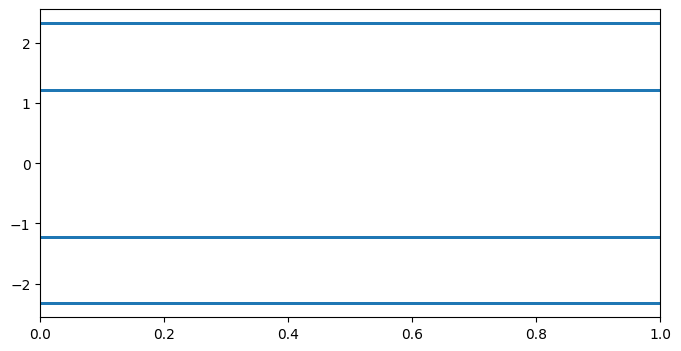

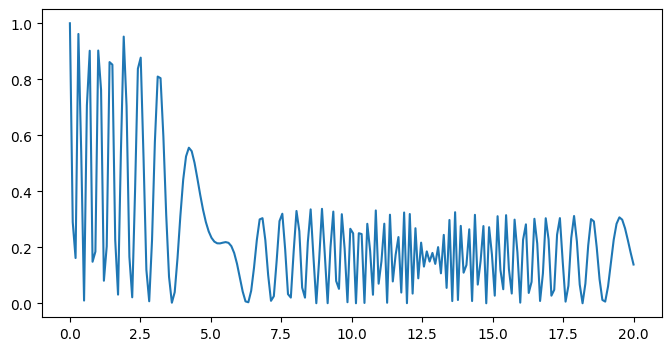

In [767]:
eigenvalues, eigenstates = (H_ind_gad + H_gad).eigenstates()
energies = {}

print((H_ind_gad + H_gad).dims)
plt.figure(figsize=(8, 4))
# Loop through both arrays
for energy, state in zip(eigenvalues, eigenstates):
    energy = np.round(energy, 10)
    
    if energy not in energies.keys():
        energies[energy] = 1
    else:
        energies[energy] += 1    
    plt.axhline(y = energy, linestyle = '-', linewidth = 2)

print(energies)

P_plus = plus_state * plus_state.dag()
P_zero = zero_state * zero_state.dag()


max_time = 10

delta_t = lambda t: 10 * (t / (max_time / 2) - 1)
evolution_gad = sesolve([[H_ind_gad, delta_t], H_gad], zero_state, times, e_ops=[P_zero])

plt.figure(figsize=(8, 4))
plt.plot(times, evolution_gad.expect[0], label=r"")


In [768]:
Had = qutip.core.gates.hadamard_transform(1)

Had_four = tensor(Had, Had, Had, Had)
basis_states = [basis(2, 0), basis(2, 1)]

zero_state = tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[0])
plus_state = Had_four * zero_state

print("Plus Hamiltonian Dimensions:", plus_state.dims)

Plus Hamiltonian Dimensions: [[2, 2, 2, 2], [1, 1, 1, 1]]


[[2, 2, 2, 2], [2, 2, 2, 2]]
{np.float64(-1.0): 8, np.float64(1.0): 8}


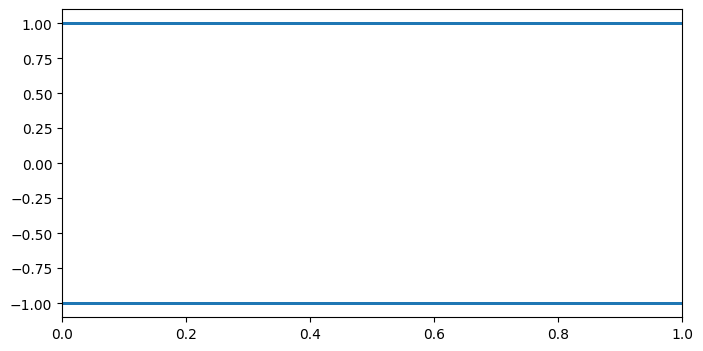

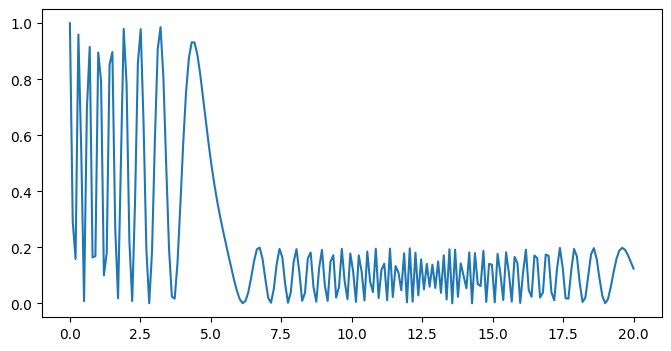

In [769]:
H_S = 0
for i in hs:
    H_S += tensor(i)


eigenvalues, eigenstates = tensor(H_S).eigenstates()
energies = {}

print(tensor(H_S).dims)
plt.figure(figsize=(8, 4))
# Loop through both arrays
for energy, state in zip(eigenvalues, eigenstates):
    energy = np.round(energy, 10)
    
    if energy not in energies.keys():
        energies[energy] = 1
    else:
        energies[energy] += 1    
    plt.axhline(y = energy, linestyle = '-', linewidth = 2)

print(energies)

P_plus = plus_state * plus_state.dag()
P_zero = zero_state * zero_state.dag()


evolution = sesolve([[H_ind_reg, delta_t], H_S], zero_state, times, e_ops=[P_zero])

plt.figure(figsize=(8, 4))
plt.plot(times, evolution.expect[0], label=r"")

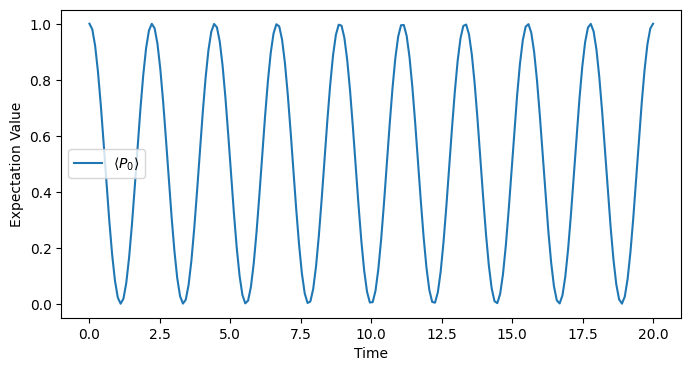

In [775]:
from qutip import krylovsolve

# Define a constant Hamiltonian (e.g., an approximation or simplified version of H_time_dep)
H_constant = H_ind_reg + H_S

# Initial state
psi0 = zero_state

# Define the observable for expectation value calculation
observables = [P_zero]

# Krylov subspace dimension
krylov_dim = 5  # Adjust this parameter as needed for accuracy vs. performance

# Solve the Schrödinger equation using the Krylov solver
evolution_krylov = krylovsolve(H_constant, psi0, times, e_ops=observables, krylov_dim=krylov_dim)

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(times, evolution_krylov.expect[0], label=r"$\langle P_{0} \rangle$")
plt.xlabel("Time")
plt.ylabel("Expectation Value")
plt.legend()
plt.show()


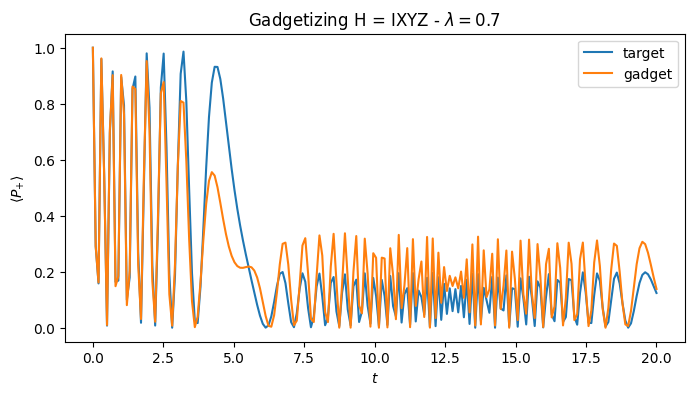

In [770]:
plt.figure(figsize=(8, 4))

plt.plot(times, evolution.expect[0], label=r"target")
plt.plot(times, evolution_gad.expect[0], label=r"gadget")
plt.legend()
plt.ylabel(r"$\langle P_{+} \rangle$")
plt.xlabel(r"$t$")

title = ""
for h in hs:
    title += tensor_to_str(h) + " + "
    
plt.title("Gadgetizing H = " + title[:-3] + r" - $\lambda = $" + f'{perturbation_factor}')
plt.show()